# HW3: The Centralized Curator Model

### Bhaven Patel
### 4/2/2019

I worked with Anthony Rentsch, Lipika Ramaswamy, and Karina Huang on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW3/HW3_Bhaven_Patel.ipynb).

## Problem 1: Tails, Trimming, and Winsorization

**(a)**<br>

$$
M(x)=\dfrac{1}{0.9n}\left(\sum_{P_0.05 \leq x_i \leq P_0.95} x_i\right) + Lap\left( \dfrac{D}{0.9n\epsilon} \right)
$$

This implementation of the Trimmed mean is $\epsilon$-DP if the trimming transformation $T$ on $x$ ($x$ is trimmed from its 5th to its 95th percentile) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we can show that the trimming transformation $T$ on $x$ is c-Lipschitz with $c=1$:<br>
Begin with $x$ and $x'$, which hold $n$=20 values each in the range [0,...,D]
$$
x = [x_1, ..., x_{20}]\\
x' = [x_2, ..., x_{21}]\\
$$

The trimming transformation $T$ applied to $x$ and $x'$ would result in
$$
T(x) = [x_2, ..., x_{19}]\\
T(x') = [x_3, ..., x_{20}]\\
$$

$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$, where $d(x, x')$ denotes the distance between datasets $x$ and $x'$ defined by the number of rows you would need to change in $x'$ to make it the same as $x$. In this case, $d(x, x') = 1$ and $d(T(x), T(x')) = 1$, so $c=1$. Thus, $T(x)$ is $c$-Lipschitz with $c=1$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{0.9n}$ and we are adding $Lap\left(\dfrac{D}{0.9n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP. From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $1$-Lipschitz, then $M\circ T$ is $1 \cdot \epsilon$-DP. Thus, this Trimmed mean algorithm is $\epsilon$-DP.


The code for the implementation is below.

In [1]:
rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}


## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Post-process a vector or matrix of DP count releases, into probabilities
normalize <- function(x){
	x[x<0] <- 0
	x <- x/sum(x)
	return(x)
}

In [2]:
# Generate a dataset of size
#
# max_value- maximum value any element in the dataset should take on
# size- number of elements to include in dataset
# 
# returns a differentially private mean release from the trimmed data

create_dataset = function(max_value, size){
    return(sample(0:max_value, size = size, replace = TRUE));
}

In [3]:
# Trimmed mean function for releasing a DP mean from data trimmed to its 5% to 95% intervals
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean = function(x, max_value, epsilon){
    n <- length(x); #get number of elements in x
    #get 5% and 95% cutoff values
    cutoffs <- quantile(x, probs = c(0.05, 0.95) )
    lower = cutoffs[1];
    upper = cutoffs[2];
    x.trimmed <- x[x >= lower & x <= upper]; #trim x
    
    sensitivity <- max_value/ (0.9*n);
    scale <- sensitivity / epsilon; #scale for Laplace noise

    sensitiveValue <- mean(x.trimmed)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue));
}

In [4]:
max_value = 10;
size = 20;

test <- create_dataset(max_value, size);
print(test)

trimmed_mean(test, max_value = max_value, epsilon = 0.4)

 [1]  7  7 10  7  1  7  7  6  0  1  2  0  3  4  8  3  8  8  3  3


$release
[1] 5.926929

$true
[1] 4.473684

<hr>

**(b)**<br>

$$
M(x)=\dfrac{1}{n}\sum_{i=1}^n [x_i]_{P_{0.05}}^{P_{0.95}} + Lap\left( \dfrac{D}{n\epsilon} \right)
$$

This implementation of the Winsorized mean is $\epsilon$-DP if the Winsorization transformation $T$ on $x$ ($x$ is clipped at its 5th and 95th percentiles) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we must determine the Lipschitz constant for the Winsorization transformation $T$ on $x$:<br>
We define $x$ as an ordered dataset with $n$ values, where $x_i \in [0,D]$:
$$
x = [x_1, ..., x_n]\\
$$
We also define $x_{0.05}$ and $x_{0.95}$ as the values from $x$ at the 5th and 95th percentiles.
<br><br>
We now define $x'$ as an ordered dataset with $n$ values identical to $x$ except that the $x_{0.05}$ value has been changed to $D$. This left shifts the values in $x'$ that are greater than $x_{0.05}$, so $x'_{0.05}\neq x_{0.05}$ and $x'_{0.95} \neq x_{0.95}$.


When the Winsorization transformation $T$ is applied to $x$ and $x'$, the results would be
$$
T(x) = [x_{0.05},...,x_{0.05}, x_t, x_{0.95}, x_{0.95}]\\
T(x') = [x'_{0.05},...,x'_{0.05}, x'_t, x'_{0.95},..., x'_{0.95}]\\
$$
where $x_t$ and $x'_t$ refer to any values between the 5th and 95th percentiles in $x$ and $x'$ respectively.

We define $d(x, x')$ as the distance between datasets $x$ and $x'$ defined by the number of values/rows you would need to change in $x'$ to make it the same as $x$. For our case, $d(x, x')=1$.
$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$. In this case, $d(T(x), T(x')) = 0.1n$ because $x_{0.05}\neq x'_{0.05}$ and $x_{0.95} \neq x'_{0.95}$. Thus, the clipped values at the ends of the dataset will be different, resulting in $0.1n$ different values between the datasets $T(x)$ and $T(x')$. Thus, $T$ is $c$-Lipschitz with $c=0.1n$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{n}$ and we are adding $Lap\left(\dfrac{D}{n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP.

From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $(0.1n)$-Lipschitz, then $M\circ T$ is $0.1n \cdot \epsilon$-DP. Thus, this Winsorized mean algorithm is $0.1n \cdot\epsilon$-DP. However when $n$ becomes very large and $\epsilon$ is fixed, this algorithm will not be $\epsilon$-DP because $T$ is not $1$-Lipschitz.

<hr>

**(c)**<br>

To use the exponential mechanism for the release of the $t$th percentile of a dataset $x$ with $n$ elements, we will first order the dataset in ascending order. Then, we make each element $x_i$ a separate bin, and we define the utility function of the bin as follows:
$$
u(x,y) = -1 * |n*t - \{\# x_i \leq y\}|
$$
For each bin, the utility function calculates the number of elements less than or equal to the value of the bin ($y$) and substracts this number from the number of elements less than the $t$th percentile ($n\cdot t)$. The absolute value of this difference is then multiplied by -1.<br>
Thus, the utility function will approaches or reaches a max of zero when the number of elements less than or equal to $y$ is equal to the number of elements less than the $t$th percentile, indicating this bin is very close to or is the actual value at the $t$th percentile. Thus, these bins are given the highest probabilities from the exponential mechanism.  As the value of the bin moves away from the true $t$th percentile in either direction, the value inside of the absolute value gets larger, leading to a larger negative value for the utility function and a smaller probability for the bin. The probability of bin $i$ is scaled up the interval between the $i$th bin and the $i+1$th bin. The probabilities are also normalized by the sum of the probabilities. <br>
Using these probabilities, a bin is chosen and then a value for the $t$th percentile is sampled from the values contained in that bin.

In [22]:
# percentile mean function for releasing a DP percentile from data 
#
# x- numeric vector of values
# tperc- percentile for which value from x should be chosen (0,100)
# epsilon- privacy loss parameter
# 
# returns a differentially private percentile release from the data
percentileRelease <- function(x, tperc, epsilon){
	n <- length(x); #get number of values in x
	bins <- sort(x, decreasing = FALSE); #making a new copy of x to keep downstream variable names the same
    sensitiveValue <- quantile(bins, probs = c(tperc)); #get the true value at the desired percentile 
    
    sensitivity = 1; #sensitivity for our utility function is 1
	likelihoods <- rep(NA, n); #create vector to hold the likelihood for each bin

	for(i in 1:n){ #calculate the utility of each bin
        #the number of values in 'x' below and equal to the current value is 'i'
#         util = n - abs(n*tperc - i); #get difference between the true percentile and fraction of
        util = -1 * abs(n*tperc - i);
        distToNextValue = 1;
        if(i != n){
            distToNextValue = bins[i+1] - bins[i] + 1; 
        }
        #the likelihood needs to get scaled by the number of integer values it covers
        likelihoods[i] <- distToNextValue * exp(epsilon * util / (2 * sensitivity));
	}
    
    #calculate the actual probabilities for each bin
	probabilities <- likelihoods/sum(likelihoods);
    
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities) # See also rmultinom()
    bInd <- which(flag == 1)[1]; #get the index of the first bin with probability
    
    #determine if this bin covers a range of values
    DPrelease <- bins[bInd]; #get initial value for DPrelease of percentile
    if(bInd + 1 < n){ #check if there is a bin larger than chosen bin
        distToNextValue = bins[bInd+1] - bins[bInd]; #determine distance between
        if(distToNextValue > 1){
            DPrelease <- runif(n=1, min=bins[bInd], max=bins[bInd+1]-1 );
        }
    }

    return(list(release=DPrelease, true=sensitiveValue))
}


To test my `percentileRelease` function, I ran the following test below. I create a dataset of 100 randomly sampled values from 0 to 100 and perform a DP release for the 30th percentile 100 times using a $\epsilon=0.5$. The true value for the 30th percentile is 27.1, and the histogram illustrates that most of the DP-released values are centered around the true value.

  [1]  22   1  78  53   6  12  30  52  12  77  73  93  11   3  28  76  92  23
 [19]  39  52  73  44  32   8  46  11  40  85  83  37  31  46  32  42  15  47
 [37]  93  66  25   7  70  41  59  98  32  53  83   5  10  53  22  11  68 100
 [55]  83  95  40  87  59  33   8  78  56  55  18  36  64  91  24  81  97  67
 [73]  91  67  19  15   2  77   3  25  24  55  33   0  51  58  64  52  57  63
 [91]   4  43  81  99   6  53  81  52  14  93
True 30th percentile: 27.1

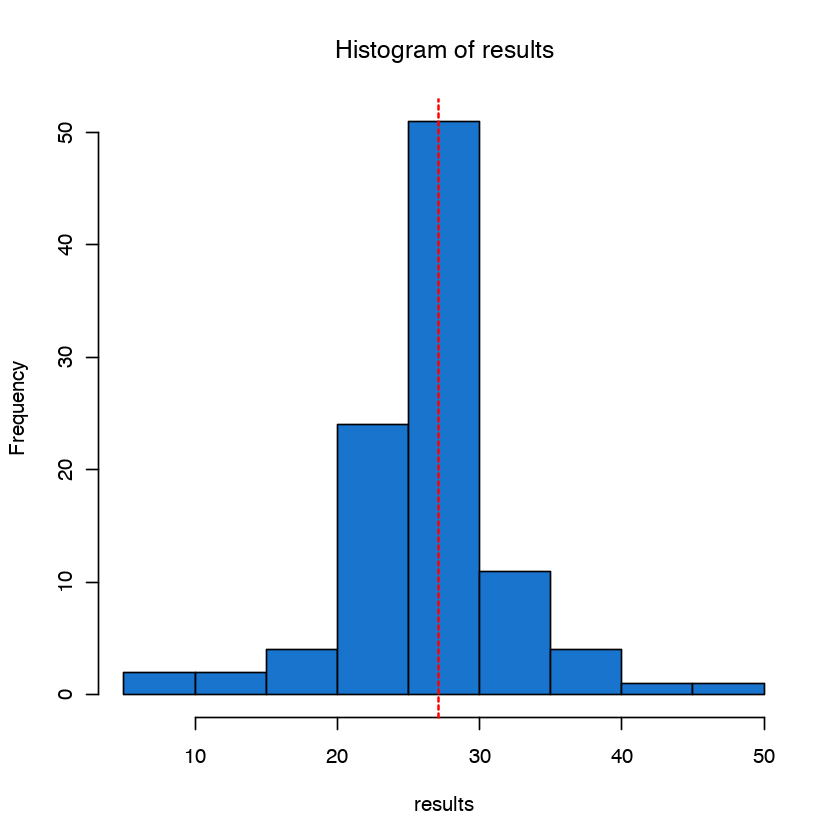

In [25]:
#test if my percentile release is working
numSims = 100;
data <- create_dataset(max_value = 100, size = 100);
print(data)
results <- c();
true_val <- -1;
for(i in 1:numSims){
    
    r <- percentileRelease(data, tperc = 0.3, epsilon = 0.5);
    true_val <- r$true
    results <- c(results, r$release);
}

cat("True 30th percentile:", true_val)

#graph the results
hist(results, col="dodgerblue3");
abline(v=true_val, col="red", lwd=1.5, lty=2);

<hr>

**(d)**<br>

In [11]:
# Trimmed mean function for releasing a DP mean from data trimmed to DP-released 5th and 95th percentiles
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- total epsilon to use as privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean_DP = function(x, epsilon){
    n <- length(x); #get number of elements in x
    #get DP releases for 5th and 95th percentiles
    lower <- percentileRelease(x, tperc = 0.05, epsilon = epsilon/3);
    upper <- percentileRelease(x, tperc = 0.95, epsilon = epsilon/3);
    
    x.trimmed <- x[x >= lower$release & x <= upper$release]; #trim x based on DP percentile values
    
    sensitivity <- (upper$release - lower$release) / (0.9*n);
    scale <- sensitivity / (epsilon/3); #scale for Laplace noise. Divide epsilon by 3

    sensitiveValue <- mean(x.trimmed);
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1);

    return(list(release=DPrelease, true=sensitiveValue));
}

To test my `trimmed_mean_DP` function, I ran the following test below. I create a dataset of 100 randomly sampled values from 0 to 100 and perform a DP release for the mean 100 times. The true value for the mean is 51.89, and the histogram illustrates that most of the DP-released values are centered around the true value.

  [1]  35  55  71  21   8  83  47  36  30  65  85  35  53  80 100  76  88  19
 [19]  29  30  78  45  27  58   4  38   4  33  15  44  44   9  51  32   0  98
 [37]  66  36  63  51  66  93  62  90  76  35  64  55  99  81  80  32  15  79
 [55]  59  99   4  65  29  14  57   9  44  96  23   7  36  77  83  43  67  44
 [73]  35  17  18  77  50  43  53  76  62  59  88  93  90  72  99  19  74  58
 [91]  30   5  58  49  77  41  34  21  50  65
[1] 51.89888


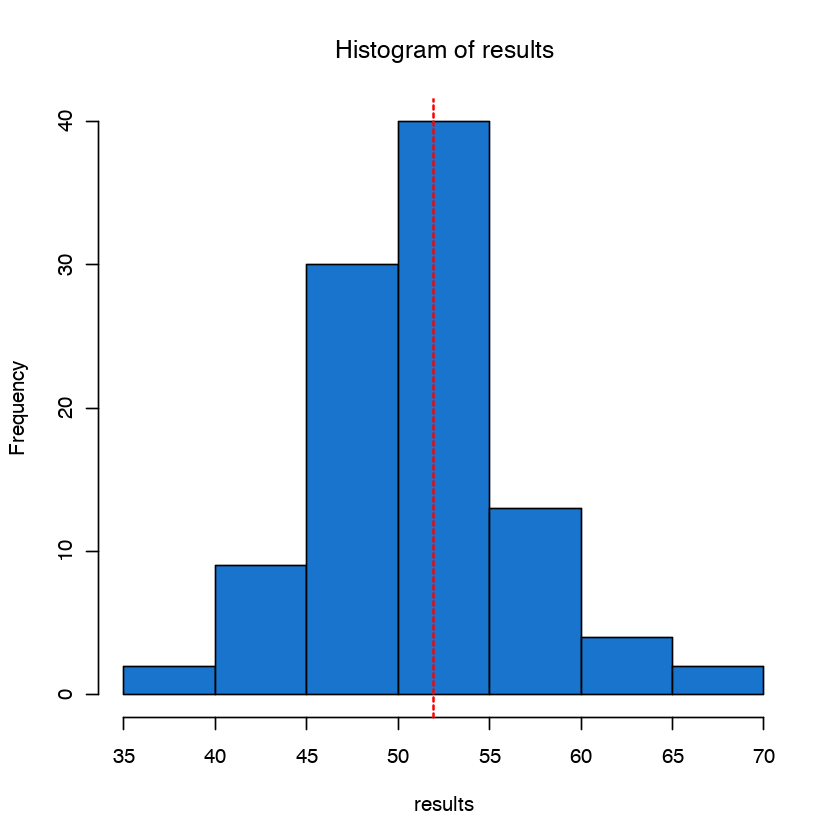

In [14]:
#test trimmed_mean_DP functon
numSims = 100;
data <- create_dataset(max_value = 100, size = 100);
print(data)
results <- c();
true_val <- -1;
for(i in 1:numSims){
    
    r <- trimmed_mean_DP(data, epsilon = 1);
    true_val <- r$true;
    results <- c(results, r$release);
}
print(true_val)

#graph the results
hist(results, col="dodgerblue3");
abline(v=true_val, col="red", lwd=1.5, lty=2);

<hr>

**(e)**<br>

## NEED to finish

<hr>

**(f)**<br>

In [15]:
#read in the the 5% PUMS Census file for Massachusetts
pums_data <- read.csv(file = "../../data/MaPUMS5full.csv");

In [16]:
##functions taken from J. Honaker's laplaceMeanReleaseFull

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Differentially private mean release
meanRelease <- function(x, lower, upper, epsilon){
    n <- length(x)
    
    sensitivity <- (upper - lower)/n
    scale <- sensitivity / epsilon

    x.clipped <- clip(x, lower, upper)
    sensitiveValue <- mean(x.clipped)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue))
}

## function to calculate the RMSE given the true values and predictions for a dataset
calcRMSE <- function(trueVals, predictions){
    diff = predictions - trueVals;
    rmse = mean(diff^2)^(0.5);
    return(rmse);
}

In [41]:
epsilon = 1;
D = 10^6;
numReleases = 100; #number of DP releases to make per PUMA region

unqPumsReg <- unique(pums_data$puma); #get vector of unique PUMA regions

nRow <- length(unqPumsReg) * numReleases * 2;
history <- matrix(NA, nrow=nRow, ncol=5); #matrix to hold results (region, iter, dp method, true mean, dprealease) 
rCounter = 1; #counter for putting into history

for(i in 1:length(unqPumsReg)){
    region <- unqPumsReg[i]; #get the region number
    regionData <- pums_data[pums_data$puma == region, ]; #get the data for this region
    regionDataIncome <- regionData$income;
    
    trueMean <- mean(regionData$income); #calculate the true mean
    
    for(n in 1:numReleases){
        #perform basic laplace mean release
        basicRelease <- meanRelease(x = regionDataIncome, lower = 0, upper = D, epsilon = epsilon);
        history[rCounter, ] <- c(region, n, 1, trueMean, basicRelease$release);
        rCounter = rCounter + 1;
        
        #perform trimmed mean release
        trimmedRelease <- trimmed_mean_DP(x = regionDataIncome, epsilon = epsilon);
        history[rCounter, ] <- c(region, n, 2, trueMean, trimmedRelease$release);
        rCounter = rCounter + 1;    
    }
    
}

In [51]:
#create dataframe from history matrix
history_df <- as.data.frame(history);
colnames(history_df) <- c("PUMA", "Iteration", "Method", "TrueMean", "DPrelease");
#convert columns to numeric type
history_df$Method[history_df$Method == 1] <- "Basic";
history_df$Method[history_df$Method == 2] <- "Trimmed";

# history_df[1:10, ] #take a look at dataframe

PUMA,Iteration,Method,TrueMean,DPrelease
100,1,Basic,27293.77,27542.74
100,1,Trimmed,27293.77,21375.52
100,2,Basic,27293.77,27304.51
100,2,Trimmed,27293.77,21418.48
100,3,Basic,27293.77,27460.42
100,3,Trimmed,27293.77,21338.39
100,4,Basic,27293.77,27225.16
100,4,Trimmed,27293.77,21299.19
100,5,Basic,27293.77,27209.68
100,5,Trimmed,27293.77,21637.59


Below, I use box-and-whisker plots  to show the distribution of the DP mean releases from the basic Laplace mechanism for each PUMA region. I ordered the plots by the true mean of each PUMA region in ascending order.

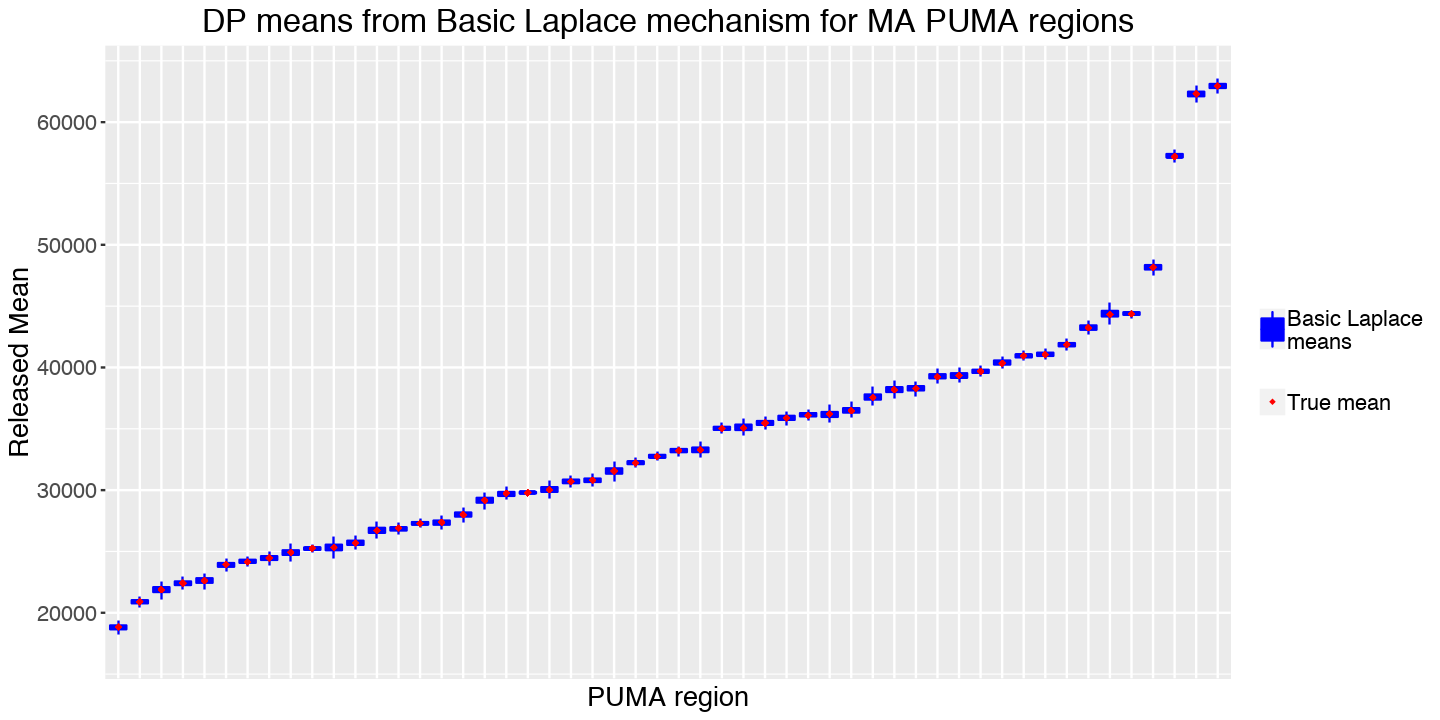

In [110]:
#make a boxplot of the basic DP-released means
library(ggplot2);
library(repr);
options(repr.plot.width=12, repr.plot.height=6);

f_size=16;

p <- ggplot(data = history_df[history_df$Method == 'Basic', ], aes(x=reorder(factor(PUMA), TrueMean), y=DPrelease)) + geom_boxplot(aes(shape='Basic Laplace\nmeans'), color='blue', fill='blue', outlier.shape = NA) + geom_point( aes(x=reorder(factor(PUMA), TrueMean), y=TrueMean, color='True mean'), shape=18);
p <- p + scale_color_manual(values=c('red')); #color the points for true means

#add labels for ax
p <- p + labs(title="DP means from Basic Laplace mechanism for MA PUMA regions", x="PUMA region", y = "Released Mean") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size));
p <- p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.title = element_blank() );
p

Below, I use box-and-whisker plots to show the distribution of the DP mean releases from the trimmed mean mechanism for each PUMA region. I ordered the plots by the true mean of each PUMA region in ascending order.

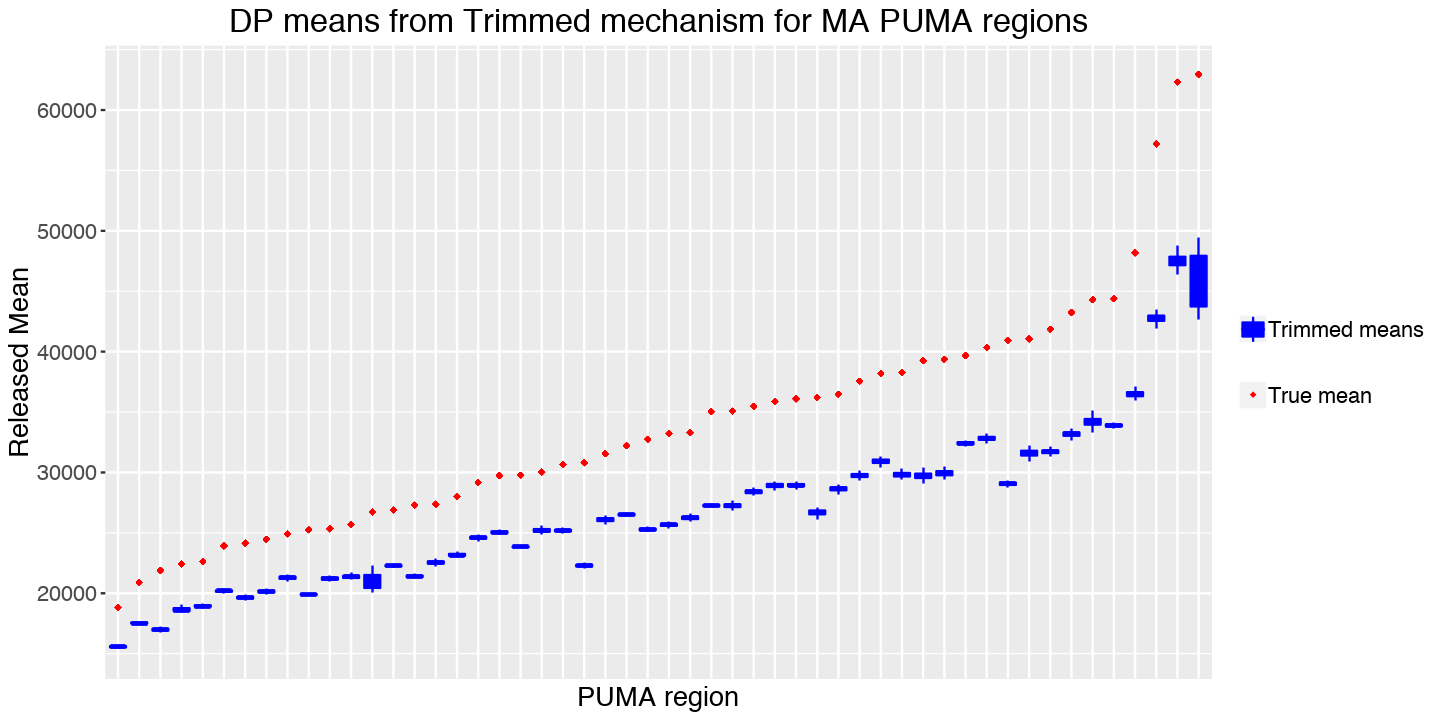

In [104]:
#make a boxplot of the trimmed DP-released means
library(ggplot2);
library(repr)
options(repr.plot.width=12, repr.plot.height=6)

f_size=16; #fontsize

p <- ggplot(data = history_df[history_df$Method == 'Trimmed', ], aes(x=reorder(factor(PUMA), TrueMean), y=DPrelease)) + geom_boxplot(aes(shape='Trimmed means'), color='blue', fill='blue', outlier.shape = NA) + geom_point( aes(x=reorder(factor(PUMA), TrueMean), y=TrueMean, color='True mean'), shape=18);
p <- p + scale_color_manual(values=c('red')); #color the points for true means

#add labels for ax
p <- p + labs(title="DP means from Trimmed mechanism for MA PUMA regions", x="PUMA region", y = "Released Mean") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size));
p <- p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.title = element_blank() );
p

In [118]:
#calculate the MSE for the basic and trimmed means
unqPumsReg <- unique(pums_data$puma); #get vector of unique PUMA regions

rmseHistory <- matrix(NA, nrow=length(unqPumsReg), ncol=4); #matrix to hold results (region, true mean, average basic release mean, average trimmed release mean) 

for(i in 1:length(unqPumsReg)){
    region <- unqPumsReg[i]; #get the region number
    regionData <- history_df[history_df$PUMA == region, ]; #get all of the DP-released means for this region
    #calculate the RMSE for the basic DP-released means for this PUMA region
    basicMechData <- regionData[regionData$Method == 'Basic', ];
    basicRMSE <- calcRMSE(trueVals = basicMechData$TrueMean , predictions = basicMechData$DPrelease);
    #calculate the RMSE for the trimmed means for this PUMA region
    trimMechData <- regionData[regionData$Method == 'Trimmed', ];
    trimRMSE <- calcRMSE(trueVals = trimMechData$TrueMean , predictions = trimMechData$DPrelease);
    
    rmseHistory[i, ] <- c(region, regionData$TrueMean[1], basicRMSE, trimRMSE);
    
}

In [120]:
#create dataframe from history matrix
rmseHistory_df <- as.data.frame(rmseHistory);
colnames(rmseHistory_df) <- c("PUMA", "True_Mean", "Basic_DP_release_RMSE", "Trimmed_DP_release_RMSE");
rmseHistory_df <- rmseHistory_df[order(rmseHistory_df$PUMA), ];
rmseHistory_df

,PUMA,True_Mean,Basic_DP_release_RMSE,Trimmed_DP_release_RMSE
1,100,27293.77,210.3797,5892.073
12,200,29772.01,142.1154,5915.077
23,300,26896.21,294.4148,4604.804
38,400,37550.28,384.9385,7806.632
48,500,39676.63,227.3873,7255.357
49,600,22622.50,358.3383,3686.960
50,700,30798.61,292.6190,8502.678
51,800,39353.84,370.6479,9432.372
52,900,36468.55,301.4142,7833.870
2,1000,38277.36,324.7172,8442.090


For the basic Laplace mechanism, we see that the distribution of the DP-released means for each PUMA region are centered around the actual mean for each PUMA region. This makes sense because very few values get clipped by our lower bound of 0 and upper bound of $10^6$, so the distribution of the clipped data is very similar to the original data. Thus, the mean of the clipped data is very close to the actual mean before Laplace noise is added to the mean of the clipped data. <br>
For the trimmed mean mechanism, we see that the distribution of the DP-released means for each PUMA region are all less than the actual mean for each PUMA region. This observation makes sense with how this algorithm is implemented because we trim the top 5% of our distribution, and since our original distribution is right-skewed, trimming the top 5% causes our trimmed mean to underestimate the true mean. <br>
Algorithm (i), the basic Laplace mean release, would work well on datasets that are left-skewed or right-skewed because clipping would not cause you to lose any values, although it does introduce some bias about the data. Using some prior knowledge of the distribution, we would be able to make informed decisions for the clipping bounds without losing too much information about the mean. <br>
Algorithm (ii), the trimmed mean release, would not work as well for datasets that are skewed because we remove outliers that are important for calculating accurate estimates of the mean. This algorithm would work better in cases in which the data is normally distributed because we would trim the left and right tails evenly and still get a good estimate of the mean because most of our data is between the 5th adn 95th percentiles. The clipping that occurs with Algorithm (i) would most likely cause us to skew a normally distributed dataset because it would be difficult to choose bounds that clipped the data evenly; it's possible that a bound we choose may even cut a significant portion of the data causing a large error in the mean estimation.

<hr>

## Problem 2: Composition

In [1]:
library("PSIlence")
## PARAMETERS
delta = 10**(-9);
globalEps = 1;

kVals <- seq(from=1, to=100, by=1); #get sequence of values for k
#create
results <- matrix( rep(NA,length(kVals)*3), nrow=length(kVals), ncol=4);

for(i in 1:length(kVals)){
    k = kVals[i];
    #calculate standard deviation for epsilon split based on basic composition
    epsBasic = globalEps / k;
    stdBasic = sqrt(2) / epsBasic;
    #calculate standard deviation for epsilon split based on advanced composition
    epsAdv = globalEps / sqrt(2*k*log(1/delta));
    stdAdv = sqrt(2) / epsAdv;
    
    #calculate standard deviation for epsilon split based on optimal composition
    init <- rep(c(0, 0), k ); 
    params <- matrix(init, nrow=k, ncol=2, byrow=TRUE); #create matrix to feed to update_parameters
    inverse <- PSIlence:::update_parameters(params=params, hold=0, eps=globalEps, del=delta)
    stdOpt = sqrt(2) / inverse[1,1];

    
    results[i, ] <- c(k, stdBasic, stdAdv, stdOpt);
}

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

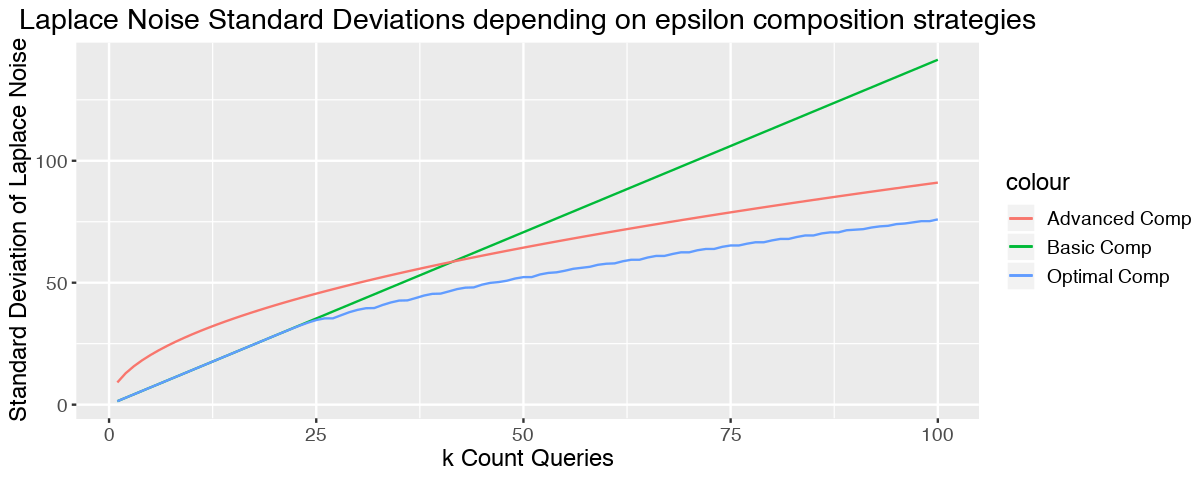

In [2]:
library(ggplot2)
library(grid)

final_results <- as.data.frame(results);
colnames(final_results) <- c("k", "Std_Basic_Comp", "Std_Adv_Comp", "Std_Opt_Comp");
f_size = 16;
fifty = 0.5;
# Plot the standard deviations 
p <- ggplot(data = final_results) + geom_line(aes(x=final_results$k, y=final_results$Std_Basic_Comp, color="Basic Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Adv_Comp, color="Advanced Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Opt_Comp, color="Optimal Comp")); 

p <- p + labs(title="Laplace Noise Standard Deviations depending on epsilon composition strategies", x="k Count Queries", y = "Standard Deviation of Laplace Noise") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));

options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p #show plot

In [10]:
#code for finding the smallest k at which Advanced and Optimal compositions improve upon basic composition
# final_results[final_results$Std_Adv_Comp < final_results$Std_Basic_Comp, ]
# final_results[final_results$Std_Opt_Comp < final_results$Std_Basic_Comp, ]

In the graph above, we can see the expected trends:
1. For basic composition, the standard deviation of the Laplace noise added to each query answer increases linearly with the number of queries. This is because $\epsilon_0$ decrease proportional to $1/k$ so more noise is added with smaller $\epsilon_0$s. <br>
2. Advanced composition adds more noise to the queries for small $k$ than basic composition. However after $k=42$, advanced composition adds less noise than basic composition for higher values of $k$, so each answer has more utility.
<br>
3. Optimal composition does better than advanced composition for every value of $k$. Optimal composition does just as good as basic composition until $k=21$, after which it does much better than basic composition. It is obvious that optimal composition provides the best utility for any value of $k$.

## Problem 3: Synthetic Data

In [ ]:
#read in the PUMS dataset
pums_df <- read.csv("../../data/MaPUMS5full.csv");

#trim dataset to 'income','educ','age' columns
pums_df_trimmed <- subset(pums_df, select = c('age', 'educ', 'income') );

#clip the income data before taking the log
pums_df_trimmed$income <- clip(x=pums_df_trimmed$income, lower=1, upper=10^6);
pums_df_trimmed$income <- log(pums_df_trimmed$income); #take the log of the income

In [3]:
## Differentially private histogram release for continuous data binned on 3 categories.
## Adapted from J. Honaker's xyHistogramRelease function
xyzHistogramRelease <- function(z, y, x, zlower, zupper, ylower, yupper, xlower, xupper, xnbins=0, ynbins=0, znbins=0, epsilon){
	n <- length(x); #get length of first vector
	if(xnbins==0){
		xlower <- floor(xlower); #floor and ceiling
		xupper <- ceiling(xupper);
		xbins <- xlower:(xupper+1); #generate vector of values to define thresholds for each bin
        xnbins <- length(xbins)-1; #actual number of bins we're using
		xgranularity <- 1; #distance between bins
		xcodebook <- xbins[1:xnbins]; #left thresholds for the bin
    } else {
    	xbins <- seq(from=xlower, to=xupper, length=xnbins+1)
    	xgranularity <- (xupper-xlower)/xnbins
    	xbins[xnbins+1] <-  xbins[xnbins+1] + xgranularity
		xcodebook <- xbins[1:xnbins] + 0.5*xgranularity
    }

	if(ynbins==0){
		ylower <- floor(ylower)
		yupper <- ceiling(yupper)
		ybins <- ylower:(yupper+1); #generate vector of values to define thresholds for each bin      
		ynbins <- length(ybins)-1; #actual number of bins we're using
		ygranularity <- 1; #distance between bins
		ycodebook <- ybins[1:ynbins]; #left thresholds for the bin
    } else {
    	ybins <- seq(from=ylower, to=yupper, length=ynbins+1)
    	ygranularity <- (yupper-ylower)/ynbins
    	ybins[ynbins+1] <-  ybins[ynbins+1] + ygranularity
    	ycodebook <- ybins[1:ynbins] + 0.5*ygranularity
    }
    
    if(znbins==0){
		zlower <- floor(zlower)
		zupper <- ceiling(zupper)
		zbins <- zlower:(zupper+1); #generate vector of values to define thresholds for each bin    
		znbins <- length(zbins)-1; #actual number of bins we're using
		zgranularity <- 1; #distance between bins
		zcodebook <- zbins[1:znbins]; #left thresholds for the bin
    } else {
    	zbins <- seq(from=zlower, to=zupper, length=znbins+1)
    	zgranularity <- (zupper-zlower)/znbins
    	zbins[znbins+1] <-  zbins[znbins+1] + zgranularity
    	zcodebook <- zbins[1:znbins] + 0.5*zgranularity
    }

    #clip x,y,z values
    x.clipped <- clip(x=x, lower=xlower, upper=xupper);
    y.clipped <- clip(x=y, lower=ylower, upper=yupper);
    z.clipped <- clip(x=z, lower=zlower, upper=zupper);

	sensitivity <- 2; #GS is 2 because changing one value changes counts of 2 bins
	scale <- sensitivity / (epsilon);
    #number of rows is the total combinations given by xnbinsn
# 	sensitiveValue <- DPrelease <- matrix(NA, nrow=xnbins*ynbins*znbins, ncol=4);
    DPrelease <- matrix(NA, nrow=xnbins*ynbins*znbins, ncol=5);
    rCounter = 1;
	for(i in 1:xnbins){
		for(j in 1:ynbins){
            for(k in 1:znbins){
                binVal <- sum(x.clipped >= xbins[i] & x.clipped < xbins[i+1] 
                              & y.clipped >= ybins[j] & y.clipped < ybins[j+1] 
                              & z.clipped >= zbins[k] & z.clipped < zbins[k+1]);
#                 sensitiveValue[rCounter, ] <- c(i, j, k, binVal); #save actual count for this bin
                dpAnswer <- binVal + rlap(mu=0, b=scale, size=1); #calculate DP release for this bin
                DPrelease[rCounter, ] <- c(xcodebook[i], ycodebook[j], zcodebook[k], binVal, dpAnswer); #
                rCounter = rCounter + 1; #update the row counter for inputting data into the matrix
            }
        }
	}

    return(list(release=DPrelease, xcodebook=xcodebook, ycodebook=ycodebook, zcodebook=zcodebook))
}

To generate a DP histogram release, I clip *age* from 18 to 100 because the PUMS survey is only taken by adults, so everyone has to be 18 years or older; I chose 100 for the upper bound on *age* arbitrarily, since most individuals should be less than 100 years old. I clip *education* from 1 to 16, since the PUMS codebook specifies these values as the lower and upper bounds for the *education* category. Lastly, I put *income* on a $\log$ (natural log) scale. <br>

I ran only 50 simulations of the DP histogram release, synthetic data generation and linear regression process because using 10 bins for income in the DP histogram release leads to a run time of 2 minutes for each simulation. The $\beta$s from the linear regression run in each of my simulations were saved to a file called *betas_from_DPreleases.csv*.

In [ ]:
#run simulations for generating synthetic data from DP histogram releases and calculating betas for linear regression coefficients
set.seed(24);
nsims <- 50;
# nsims <- 3;

betahistory <-matrix(NA, nrow=nsims, ncol=3); #create history matrix to store

Sys.time() #for timing
for(i in 1:nsims){
    message(paste("on simulation ", i)); #status message to print out
	xyzOut <- xyzHistogramRelease(z=pums_df_trimmed$income, y=pums_df_trimmed$educ, x=pums_df_trimmed$age, zlower=log(1), zupper=log(10^6), ylower=1, yupper=16, xlower=18, xupper=100, znbins=10, epsilon=0.5);
    
    #normalize the DP histogram release counts into probabilities
	syn.prob <- as.vector(normalize(xyzOut$release[,5]));
    #sample row indices from the binned data using calculated probabilities
	syn.x <- sample(x=1:nrow(xyzOut$release), size=nrow(pums_df_trimmed), prob=syn.prob, replace = TRUE);
    synData <- xyzOut$release[syn.x, ]; #generate synthetic data
    synData <- synData[, 1:3]; #we only need the first three columns, which correspond to age, education, income

	sampleOutput <- lm(synData[,3] ~ synData[,1] + synData[,2]); #generate linear model from the data
    
    #adding noise drives the correlation values down becausse we have less signal
	betahistory[i,] <- c(sampleOutput$coef[1], sampleOutput$coef[2], sampleOutput$coef[3]);
}
Sys.time() #for timing

#save the betas data from these simulations since it takes awhile to run
betahistory_df <- as.data.frame(betahistory);
colnames(betahistory_df) <- c("beta0", "beta1Age", "beta2Educ");
#save the data
write.csv(betahistory_df, file='betas_from_DPreleases.csv', row.names=FALSE);


In [6]:
#calculate true betas
pums_df_trimmed_clipped <- pums_df_trimmed; #create copy of pums_df_trimmed
pums_df_trimmed_clipped$age[pums_df_trimmed_clipped$age < 18] <- 18; #lower bound of age is 18
pums_df_trimmed_clipped$age[pums_df_trimmed_clipped$age > 100] <- 100; #upper bound of age is 100
pums_df_trimmed_clipped$income[pums_df_trimmed_clipped$income < log(1)] <- log(1); #lower bound of log(income) is 0
pums_df_trimmed_clipped$income[pums_df_trimmed_clipped$income > log(10^6)] <- log(10^6); #upper bound of log(income) is 6

In [7]:
true.output <- lm(pums_df_trimmed_clipped$income ~ pums_df_trimmed_clipped$age + pums_df_trimmed_clipped$educ)
true.slope <- coef(true.output);
#save true beta values
trueBeta0 <- true.slope[1];
trueBeta1 <- true.slope[2];
trueBeta2 <- true.slope[3];

trueBetas <- c(trueBeta0, trueBeta1, trueBeta2);
print(trueBetas)

                 (Intercept)  pums_df_trimmed_clipped$age 
                  6.07885272                   0.01817699 
pums_df_trimmed_clipped$educ 
                  0.21980434 


To calculate a baseline MSE for $\tilde\beta$, I generated 100 bootstrapped datasets with the same number of rows as the original PUMA dataset and calculated the $\beta$s for linear regression for each bootstrapped dataset. The $\beta$s s from the linear regression run for each of my bootstrapped datasets were saved to a file called *betas_from_bootstraps.csv*.

In [ ]:
#Calculating regression betas for 100 bootstrapped datasets, so we can calculate a baseline MSE
set.seed(24);
nBootstraps = 100;

bsHistory <-matrix(NA, nrow=nBootstraps, ncol=3);
for(i in 1:nBootstraps){
	#sample row indices for bootstrapped dataset
	bs.x <- sample(x=1:nrow(pums_df_trimmed_clipped), size=nrow(pums_df_trimmed_clipped), replace = TRUE);
    bootstrappedData <- pums_df_trimmed_clipped[bs.x, ]; #get rows for bootstrapped data

    #generate linear model from the bootstrapped data: income ~ age + educ
    bsOutput <- lm(bootstrappedData[,3] ~ bootstrappedData[,1] + bootstrappedData[,2]); 
        
    #adding noise drives the correlation values down becausse we have less signal
	bsHistory[i,] <- c(bsOutput$coef[1], bsOutput$coef[2], bsOutput$coef[3]);

}
bsHistory_df <- as.data.frame(bsHistory);
colnames(bsHistory_df) <- c("beta0", "beta1Age", "beta2Educ");
#save the data so I don't have to run this again
write.csv(bsHistory_df, file='betas_from_bootstraps.csv', row.names=FALSE);

In [ ]:
#read in the betas from bootstrapping
bootstrappedBetas <- read.csv("./betas_from_bootstraps.csv", header = T);

#read in betas from synthetic data generation
synDataBetas <- read.csv("./betas_from_DPreleases.csv", header = T);

In [10]:
##function to calculate the MSE between the true Betas and Betas generated from the synthetic data or bootstrapped data
##
## trueBetas <- vector of the true Betas
## sampledBetas <- dataframe or matrix of Betas, where the i-th column is a list of calculated Betas for the i-th Beta in trueBetas

#####NEED TO FIX
calcMSE <- function(trueBetas, sampledBetas){
    numBetas <- length(trueBetas);
    mseHistory <- matrix(NA, nrow=numBetas, ncol=4);
    for(i in 1:numBetas){
        betaDiffs <- trueBetas[i] - sampledBetas[,i]; #subtract calculated Betas from true Beta
        biasBeta <- mean(betaDiffs); #calculate bias
#         varBeta <- mean(betaDiffs^2); #calculate the variance
        varBeta <- var(sampledBetas[,i]);
        mseBeta <- biasBeta^2 + varBeta; #calculate the MSE
        betaName <- colnames(sampledBetas)[i];
        mseHistory[i, ] <- c(betaName, mseBeta, biasBeta, varBeta);
    }
    
    mseHistory_df <- as.data.frame(mseHistory);
    colnames(mseHistory_df) <- c("Beta", "MSE", "Bias", "Variance");
    return(mseHistory_df);
}

In [13]:
#calculate the MSE, bias, and variance of each Beta from the boostrapped dataset betas
bsMseDf <- calcMSE(trueBetas = trueBetas, sampledBetas =  bootstrappedBetas);
print("Baseline MSE for Betas")
bsMseDf

[1] "Baseline MSE for Betas"


Beta,MSE,Bias,Variance
beta0,0.000865031184637296,-0.00163403978940059,0.000862361098603951
beta1Age,1.08883392987777e-07,-3.33978490399931e-06,1.08872238824572e-07
beta2Educ,4.12661071656176e-06,0.000165008965749907,4.09938275778391e-06


In [14]:
#calculate the MSE, bias, and variance of each Beta from the betas from the synthetic data betas
syndMseDf <- calcMSE(trueBetas = trueBetas, sampledBetas = synDataBetas);
print("MSE for Betas from synthetic data")
syndMseDf

[1] "MSE for Betas from synthetic data"


Beta,MSE,Bias,Variance
beta0,0.470704325913064,-0.683317716276776,0.00378122453535517
beta1Age,0.000127451268460345,0.0112625581853796,6.06051581285227e-07
beta2Educ,0.000759414560293447,0.0272665360158189,1.59505739914953e-05


The values for the $\beta$s are quite small because we are putting *income* on a $\log$ scale, while not transforming the scales for *age* or *education*, which have broader ranges.

The MSE values for the $\beta$s generated from the sampled data are mostly driven by the variances because the squared-biases are much smaller than the variances. The biases are quite small and very close to zero, so in expectation the bias for these $\beta$s is zero, but there is a larger spread in the values.

The MSE values for the $\beta$s generated from the DP-releases are 2-3 orders of magnitude higher than the MSE values for the $\beta$s generated from the sampled data. The biases and variances for the DP-released $\beta$s are also higher than those for the sampled-data $\beta$s. Additionally, the bias and variances terms seem to contribute about equally to the MSE for the DP-released $\beta$s because the squared-biases are on the same order of magnitude as the variances. Thus, we can conclude that the synthetic data from the DP-releases result in $\beta$s that have higher biases and variances, which results in more error than the sampling procedure. This is reasonable since the DP-released histogram bins *income* into 10 bins and then generates synthetic data based on those bins, so the synthetic data loses some information and is more granular than the true data. The sampled data uses the true *log(income)* values, so these data should generate $\beta$s that better reflect the true-$\beta$. Therefore in this case, the error due to the DP-releases is higher than the sampling error. This could be fixed by using more bins for *income* in the DP-histogram release because the synthetic data would better reflect the true data.